In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


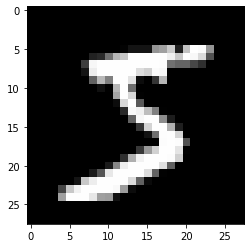

In [19]:
from datasets import MNISTDataset

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=100)





In [20]:
print('Training.images shape: ', data.train_data.shape)
print('Training.labels shape: ', data.train_labels.shape)
print('Shape of an image: ', data.train_data[0].shape)
temp = tf.one_hot(data.train_labels[0],10)
temp = temp.eval(session=tf.compat.v1.Session())
print('Example label: ', temp)

Training.images shape:  (60000, 784)
Training.labels shape:  (60000,)
Shape of an image:  (784,)
Example label:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


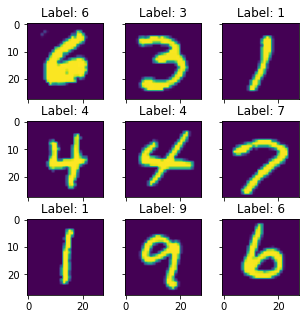

In [21]:
# Review a few images
image_list = data.train_data[0:9]
one_hot = tf.one_hot(data.train_labels[0:9],10)
one_hot = one_hot.eval(session=tf.compat.v1.Session())
image_list_labels = one_hot

# https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#imagegrid
fig = plt.figure(1, (5., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for i in range(len(image_list)):
    image = image_list[i].reshape(28,28)
    grid[i].imshow(image)
    grid[i].set_title('Label: {0}'.format(image_list_labels[i].argmax()))

plt.show()

In [22]:
sess = tf.InteractiveSession()

C:\Users\roman\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\client\session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [23]:
# Functions for creating weights and biases
# https://www.tensorflow.org/get_started/mnist/pros
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [24]:
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [25]:
# y = (Wx +b)
# https://www.tensorflow.org/get_started/mnist/pros

# Input layer
x_image = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Flatten - keras 'flatten'
x_flat = tf.reshape(x_pool2, [-1, 7*7*64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [26]:
# Probabilities - output from model (not the same as logits)
y = tf.nn.softmax(y_conv)

In [27]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [28]:
# Setup to test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [29]:
# Initilize all global variables
sess.run(tf.global_variables_initializer())

In [35]:
# Train model
# Run once to get the model to a good confidence level
for i in range(1000):
    batch = data.next_batch()
    one_hot = tf.one_hot(batch[1],10)
    one_hot = one_hot.eval(session=tf.compat.v1.Session())
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: one_hot, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: one_hot, keep_prob: 0.4})

step 0, training accuracy 0.08
step 200, training accuracy 0.9
step 400, training accuracy 0.95
step 600, training accuracy 0.99
step 800, training accuracy 0.96


In [38]:
one_hot = tf.one_hot(data.test_labels[0:500],10)
one_hot = one_hot.eval(session=tf.compat.v1.Session())

print("test accuracy %g"%accuracy.eval(feed_dict={x: data.test_data[0:500], 
                                                  y_: one_hot, keep_prob: 1.0}))

test accuracy 0.972


In [37]:
def plot_predictions(image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None

In [44]:
# Get 10 2s [:,2] from top 500 [0:500], nonzero returns tuple, get index[0], then first 10 [0:10]
one_hot = tf.one_hot(data.test_labels[0:500],10)
one_hot = one_hot.eval(session=tf.compat.v1.Session())

index_of_4s = np.nonzero(one_hot[:,4])[0][0:10]
x_batch = data.test_data[index_of_4s]

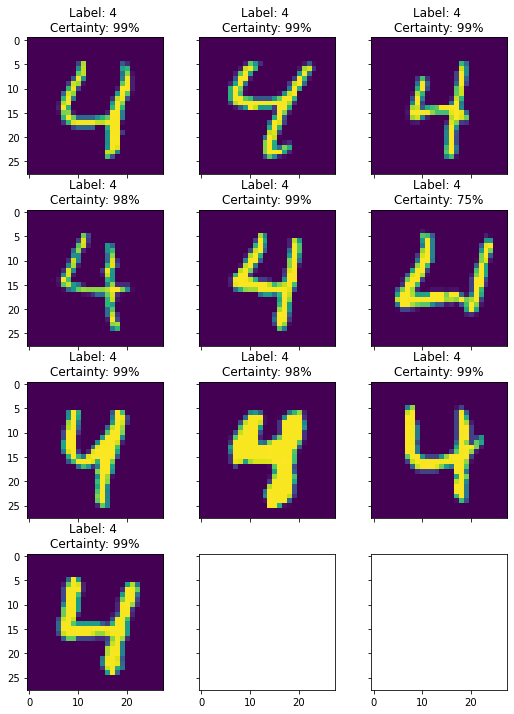

In [45]:
plot_predictions(x_batch)

In [46]:
# Mostly inspired by:
# https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture
def create_plot_adversarial_images(x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for _ in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image, keep_prob: 1.0}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
        
        # Create darray of 3 images - orig, noise/delta, adversarial
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)

        # Print/plot images and return probabilities
        probs = plot_predictions(img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
    
    return probs_per_step

In [55]:
# Pick a random 4 image from first 1000 images 
# Create adversarial image and with target label 9
one_hot = tf.one_hot(data.test_labels[0:1000],10)
one_hot = one_hot.eval(session=tf.compat.v1.Session())

index_of_4s = np.nonzero(one_hot[:,4])[0]
rand_index = np.random.randint(0, len(index_of_4s))
image_norm = data.test_data[index_of_4s[rand_index]]
image_norm = np.reshape(image_norm, (1, 784))
label_adv = [0,0,0,0,0,0,0,0,0,1] # one hot encoded, adversarial label 9

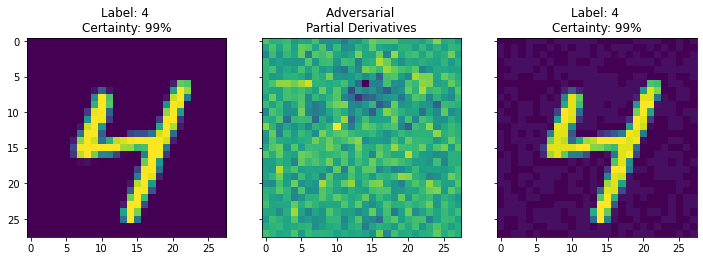

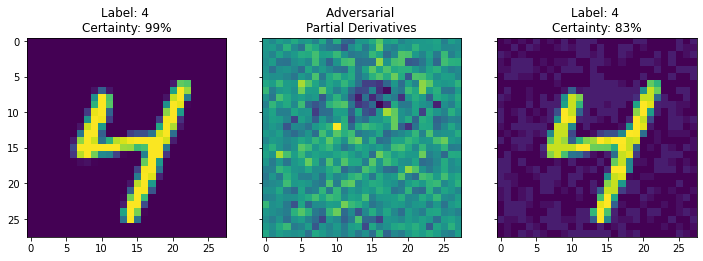

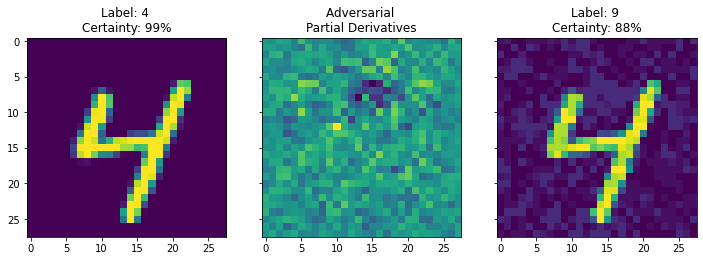

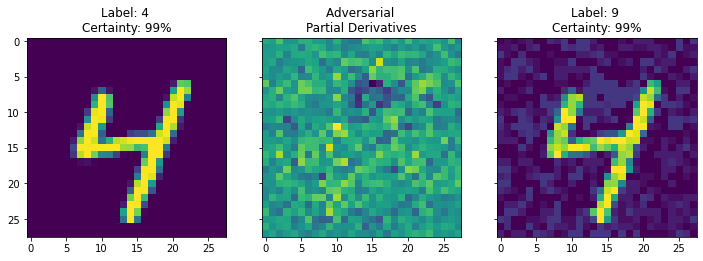

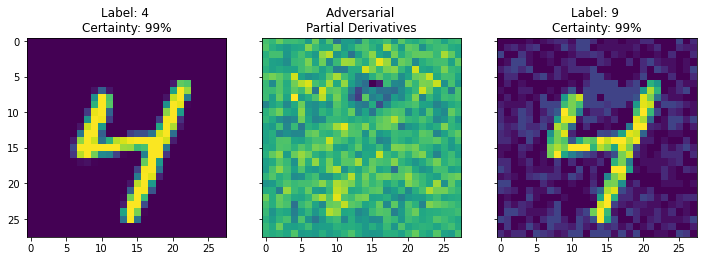

[]

In [52]:
# Plot adversarial images
# Over each step, model certainty changes from 4 to 9
create_plot_adversarial_images(image_norm, label_adv, lr=0.2, n_steps=5)

In [ ]:
random_noise = np.random.random((1, 784))